In [1]:
%load_ext autoreload
%autoreload 2

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

<IPython.core.display.Javascript object>

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

<IPython.core.display.Javascript object>

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

<IPython.core.display.Javascript object>

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

<IPython.core.display.Javascript object>

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

<IPython.core.display.Javascript object>

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

<IPython.core.display.Javascript object>

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

<IPython.core.display.Javascript object>

In [9]:
#export
def flatten(x):
    return x.view(x.shape[0], -1)

<IPython.core.display.Javascript object>

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels. Images in PyTorch are expected to be in this format:
`bs x channels x height x width`

In [10]:
#export
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

<IPython.core.display.Javascript object>

We can now define a simple CNN.

$$H = \lfloor\frac{H + 2 * padding - kernel\_H}{stride}\rfloor + 1$$

In [11]:
#export
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2),
        nn.ReLU(),  #14
        nn.Conv2d(8, 16, 3, padding=1, stride=2),
        nn.ReLU(),  # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2),
        nn.ReLU(),  # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2),
        nn.ReLU(),  # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c))

<IPython.core.display.Javascript object>

In [12]:
nn.AdaptiveAvgPool2d(1)(torch.ones(bs, 32, 5, 5)).shape

torch.Size([512, 32, 1, 1])

<IPython.core.display.Javascript object>

In [13]:
nn.AdaptiveAvgPool2d(1)(torch.ones(bs, 32, 5, 5)).view(bs, -1).shape

torch.Size([512, 32])

<IPython.core.display.Javascript object>

In [14]:
model = get_cnn_model(data)
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

<IPython.core.display.Javascript object>

Basic callbacks from the previous notebook:

In [15]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

<IPython.core.display.Javascript object>

In [16]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

<IPython.core.display.Javascript object>

In [17]:
%time run.fit(1, learn)

train: [1.9479753125, tensor(0.3206)]
valid: [0.778451416015625, tensor(0.7428)]
CPU times: user 8.21 s, sys: 650 ms, total: 8.86 s
Wall time: 4.51 s


<IPython.core.display.Javascript object>

## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [18]:
# Somewhat more flexible way
device = torch.device('cuda', 0)
device

device(type='cuda', index=0)

<IPython.core.display.Javascript object>

In [19]:
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device

    def begin_fit(self):
        self.model.to(self.device)

    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(
            self.device)

<IPython.core.display.Javascript object>

If we have only one GPU, then `.cuda()` would work after we set the device like below. Also, it is most common to have only one GPU.

In [20]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

AttributeError: module 'torch._C' has no attribute '_cuda_setDevice'

<IPython.core.display.Javascript object>

In [ ]:
#export
class CudaCallback(Callback):
    def begin_fit(self):
        self.model.cuda()

    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [ ]:
cbfs.append(CudaCallback)

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(3, learn)

Now, that's definitely faster!

I don't have a GPU so I wont run the Cuda section.

## Refactor model

First we can regroup all the conv/relu in a single function:

In [21]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride),
                         nn.ReLU())

<IPython.core.display.Javascript object>

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback. This way, the callback will be generlizable by passing any function we want to transform X, and it should take care of transforming it before feeding it to the model.

In [22]:
#export
class BatchTransformXCallback(Callback):
    _order = 2

    def __init__(self, tfm):
        self.tfm = tfm

    def begin_batch(self):
        self.run.xb = self.tfm(self.xb)


def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1, ) + size))

    return _inner

<IPython.core.display.Javascript object>

In [23]:
mnist_view = view_tfm(1,28,28)
cbfs += [partial(BatchTransformXCallback, mnist_view), Recorder]
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7ffaae6123b0>),
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7ffa77fbfcb0>),
 exp.nb_05b.Recorder]

<IPython.core.display.Javascript object>

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [24]:
nfs = [8, 16, 32, 32]

<IPython.core.display.Javascript object>

In [25]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i + 1], 5 if i == 0 else 3)
        for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1),
         Lambda(flatten),
         nn.Linear(nfs[-1], data.c)]


def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

<IPython.core.display.Javascript object>

And this helper function will quickly give us everything needed to run the training.

In [26]:
#export
def get_runner(model,
               data,
               lr=0.6,
               cbs=None,
               opt_func=None,
               loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

<IPython.core.display.Javascript object>

In [27]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

<IPython.core.display.Javascript object>

In [28]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

<IPython.core.display.Javascript object>

In [29]:
run.fit(3, learn)

train: [1.75274609375, tensor(0.4185)]
valid: [0.7350322265625, tensor(0.7680)]
train: [0.3539391015625, tensor(0.8937)]
valid: [0.2046883056640625, tensor(0.9372)]
train: [0.190644609375, tensor(0.9421)]
valid: [0.1554486328125, tensor(0.9524)]


<IPython.core.display.Javascript object>

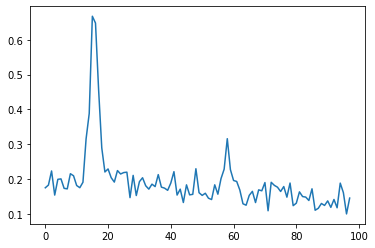

<IPython.core.display.Javascript object>

In [30]:
run.recorder.plot_loss()

## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [31]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x

    def __iter__(self):
        return iter(self.layers)

<IPython.core.display.Javascript object>

In [32]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
model

SequentialModel(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): AdaptiveAvgPool2d(output_size=1)
    (5): Lambda()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
)

<IPython.core.display.Javascript object>

In [33]:
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

<IPython.core.display.Javascript object>

In [34]:
run.fit(2, learn)

train: [1.65895078125, tensor(0.4313)]
valid: [0.6559232421875, tensor(0.7958)]
train: [0.32591693359375, tensor(0.9003)]
valid: [0.28825322265625, tensor(0.9094)]


<IPython.core.display.Javascript object>

Now we can have a look at the means and stds of the activations at the beginning of training.

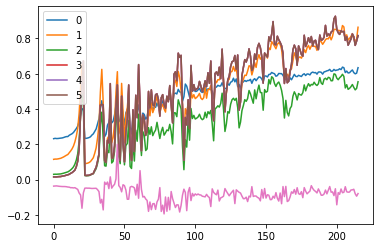

<IPython.core.display.Javascript object>

In [35]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(6))

From this chart, we don't know if after the spikes in the beginning of the training the gradients are not very close to zero. This means that the majority of the parameters are close to zero and not much training is done.

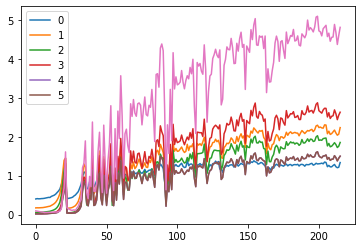

<IPython.core.display.Javascript object>

In [36]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6))

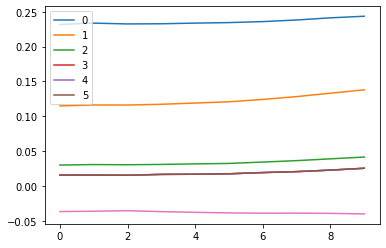

<IPython.core.display.Javascript object>

In [37]:
for l in model.act_means:
    plt.plot(l[:10])
plt.legend(range(6));

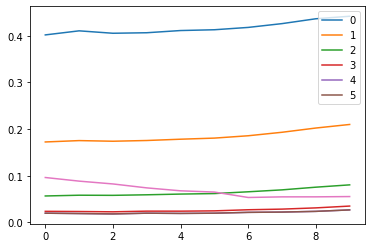

<IPython.core.display.Javascript object>

In [38]:
for l in model.act_stds:
    plt.plot(l[:10])
plt.legend(range(6));

It is very obvious that later layers are not training since their means and stds are very close to zero. That is because the gradients at the beginning were very big that the parameters of those layers kinda fall of cliff and have to restart again.

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [39]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

<IPython.core.display.Javascript object>

In [40]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

<IPython.core.display.Javascript object>

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [41]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

<IPython.core.display.Javascript object>

In [42]:
for i, module in enumerate(model): 
    module.register_forward_hook(partial(append_stats, i))

<IPython.core.display.Javascript object>

In [43]:
run.fit(1, learn)

train: [2.25264953125, tensor(0.2005)]
valid: [2.2941412109375, tensor(0.1064)]


<IPython.core.display.Javascript object>

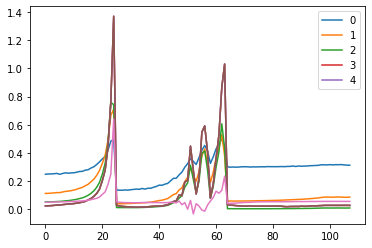

<IPython.core.display.Javascript object>

In [44]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [45]:
#export
def children(m):
    return list(m.children())


class Hook:
    def __init__(self, module, func, is_forward=True):
        self.is_forward = is_forward
        if self.is_forward:
            self.hook = module.register_forward_hook(partial(func, self))
        else:
            self.hook = module.register_backward_hook(partial(func, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()


def compute_stats(hook, module, inp, outp):
    '''Compute the means and std of each layer.'''
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    if not hook.is_forward:
        inp = inp[0], outp = outp[0]
    hook.stats[0].append(outp.data.mean())
    hook.stats[1].append(outp.data.std()) 

<IPython.core.display.Javascript object>

In [46]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

<IPython.core.display.Javascript object>

In [47]:
hooks = [Hook(l, compute_stats, True) for l in children(model[:4])]

<IPython.core.display.Javascript object>

In [48]:
run.fit(2, learn)

train: [1.95067671875, tensor(0.3108)]
valid: [1.138912109375, tensor(0.6323)]
train: [0.4911637890625, tensor(0.8461)]
valid: [0.290385595703125, tensor(0.9081)]


<IPython.core.display.Javascript object>

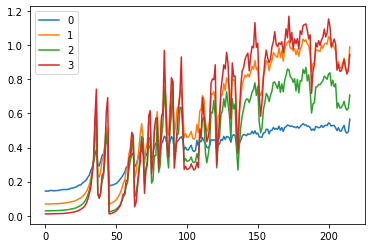

<IPython.core.display.Javascript object>

In [49]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

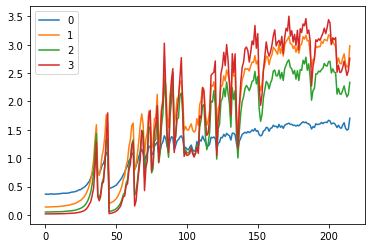

<IPython.core.display.Javascript object>

In [50]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [51]:
#export
class ListContainer():
    def __init__(self, items): 
        self.items = listify(items)

    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)):
            return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self):
        return len(self.items)
    
    def __iter__(self):
        return iter(self.items)
    
    def __setitem__(self, i, o):
        self.items[i] = o
    
    def __delitem__(self, i):
        del(self.items[i])
    
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

<IPython.core.display.Javascript object>

In [52]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<IPython.core.display.Javascript object>

In [53]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

<IPython.core.display.Javascript object>

In [54]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

<IPython.core.display.Javascript object>

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [55]:
#export
class Hooks:
    def __init__(self, modules, func, is_forward):
        self.hooks = [Hook(module, func, is_forward) for module in modules]

    def __getitem__(self, idx):
        return self.hooks[idx]

    def __len__(self):
        return len(self.hooks)

#     def __iter__(self):
#         return iter(self.hooks)

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def remove(self):
        for hook in self.hooks:
            hook.remove()

    def __del__(self):
        self.remove()

<IPython.core.display.Javascript object>

In [56]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

<IPython.core.display.Javascript object>

In [57]:
hooks = Hooks(model, compute_stats, True)
hooks

<IPython.core.display.Javascript object>

In [58]:
hooks.remove()

<IPython.core.display.Javascript object>

In [59]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x)

<IPython.core.display.Javascript object>

In [60]:
x.mean(),x.std()

(tensor(-0.0114), tensor(0.9869))

<IPython.core.display.Javascript object>

In [61]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1433, grad_fn=<MeanBackward0>),
 tensor(0.3199, grad_fn=<StdBackward0>))

<IPython.core.display.Javascript object>

In [62]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

<IPython.core.display.Javascript object>

In [63]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4762, grad_fn=<MeanBackward0>),
 tensor(0.9072, grad_fn=<StdBackward0>))

<IPython.core.display.Javascript object>

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.34199671875, tensor(0.1253)]
valid: [2.3013263671875, tensor(0.1064)]
train: [2.161155625, tensor(0.2162)]
valid: [2.3306375, tensor(0.0947)]


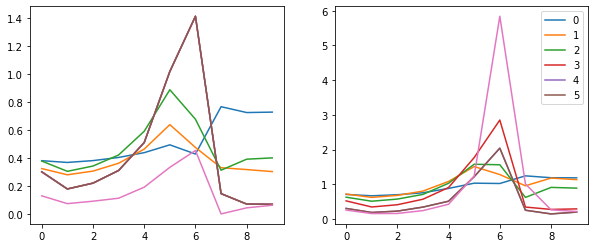

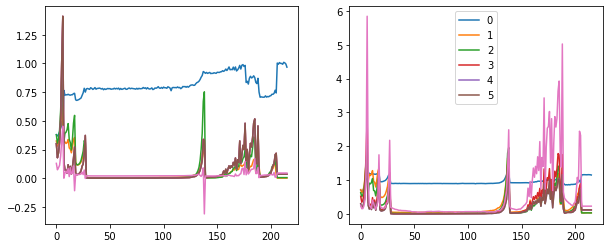

<IPython.core.display.Javascript object>

In [64]:
model = get_cnn_model(data, nfs)
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

with Hooks(model, compute_stats, True) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [65]:
#export
def children(m):
    return list(m.children())


class Hook:
    def __init__(self, module, func, is_forward=True, **kwargs):
        self.is_forward = is_forward
        if self.is_forward:
            self.hook = module.register_forward_hook(partial(func, self, **kwargs))
        else:
            self.hook = module.register_backward_hook(partial(func, self, **kwargs))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

<IPython.core.display.Javascript object>

In [66]:
#export
class Hooks:
    def __init__(self, modules, func, is_forward, **kwargs):
        self.hooks = [Hook(module, func, is_forward, **kwargs) for module in modules]

    def __getitem__(self, idx):
        return self.hooks[idx]

    def __len__(self):
        return len(self.hooks)

    def __iter__(self):
        return iter(self.hooks)

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def remove(self):
        for hook in self.hooks:
            hook.remove()

    def __del__(self):
        self.remove()

<IPython.core.display.Javascript object>

In [67]:
def compute_stats(hook, module, inp, outp, bins=40, hist_range=(0, 10)):
    """Compute the means and std of each layer."""
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    if not hook.is_forward:
        inp = inp[0], outp = outp[0]
    hook.stats[0].append(outp.data.mean().cpu())
    hook.stats[1].append(outp.data.std().cpu())
    hook.stats[2].append(outp.data.cpu().histc(
        bins, *hist_range))  #histc isn't implemented on the GPU

<IPython.core.display.Javascript object>

In [68]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

<IPython.core.display.Javascript object>

In [69]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

<IPython.core.display.Javascript object>

In [70]:
with Hooks(model, compute_stats, True, bins=40, hist_range=(0, 10)) as hooks:
    run.fit(1, learn)

train: [2.1019821875, tensor(0.2670)]
valid: [1.03615263671875, tensor(0.6717)]


<IPython.core.display.Javascript object>

In [71]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

<IPython.core.display.Javascript object>

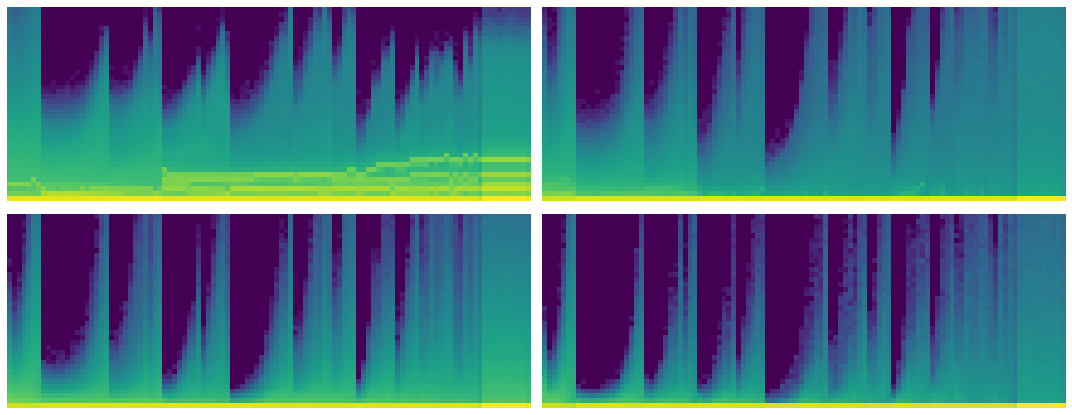

<IPython.core.display.Javascript object>

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [73]:
(len(train_ds) / bs) + len(valid_ds) / (bs * 2)

107.421875

<IPython.core.display.Javascript object>

In [74]:
# Number of iteration for both train and valid
len(hooks[1].stats[0])

108

<IPython.core.display.Javascript object>

In [75]:
# Number of bins
hooks[0].stats[-1][0].shape

torch.Size([40])

<IPython.core.display.Javascript object>

From the histograms, we can easily get more informations like the min or max of the activations

In [76]:
h1 = torch.stack(h.stats[2]).t().float()
h1.shape

torch.Size([40, 108])

<IPython.core.display.Javascript object>

In [77]:
def get_min(hook, bins_range):
    res = torch.stack(hook.stats[2]).t().float()
    return res[slice(*bins_range)].sum(0) / res.sum(0)

<IPython.core.display.Javascript object>

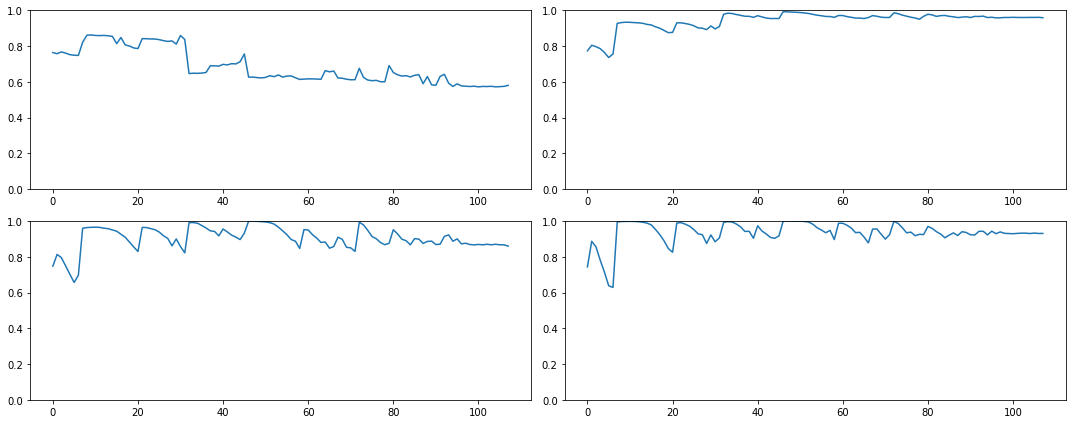

<IPython.core.display.Javascript object>

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h, (0, 2)))
    ax.set_ylim(0, 1)
plt.tight_layout()

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [79]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [
        layer(nfs[i], nfs[i + 1], 5 if i == 0 else 3, **kwargs)
        for i in range(len(nfs) - 1)
    ] + [nn.AdaptiveAvgPool2d(1),
         Lambda(flatten),
         nn.Linear(nfs[-1], data.c)]


def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks // 2, stride=stride),
                         GeneralRelu(**kwargs))


class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: 
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x


def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()


def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

<IPython.core.display.Javascript object>

In [80]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

<IPython.core.display.Javascript object>

train: [0.4795501953125, tensor(0.8505)]
valid: [0.19211416015625, tensor(0.9399)]


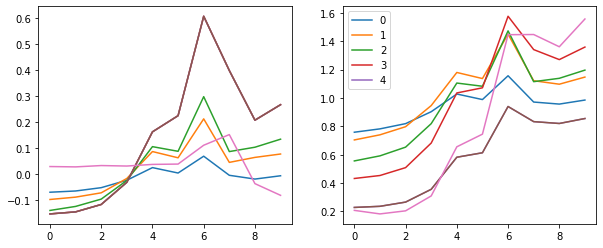

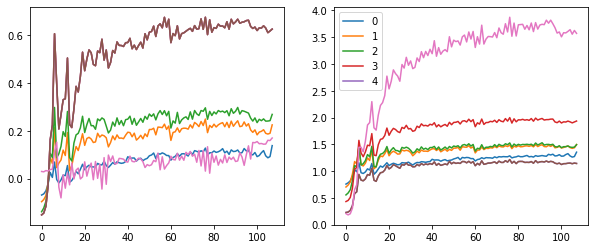

<IPython.core.display.Javascript object>

In [81]:
with Hooks(model, compute_stats, True, bins=40, hist_range=(-7, 7)) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

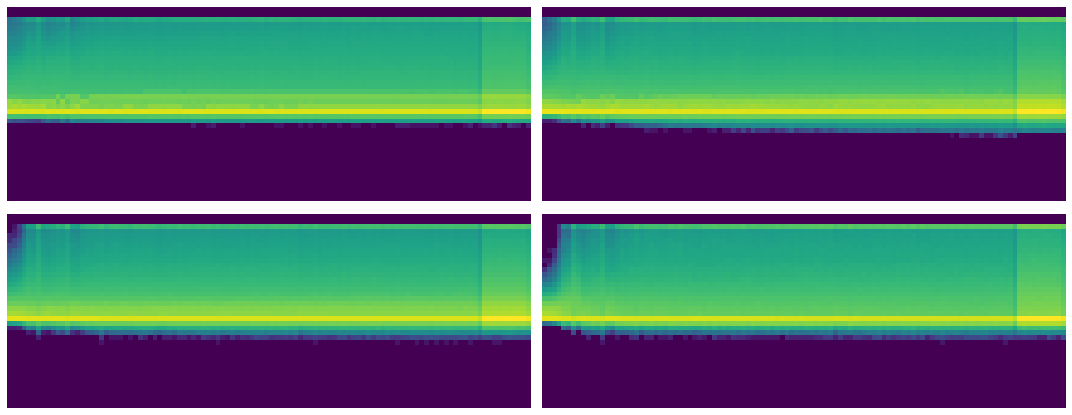

<IPython.core.display.Javascript object>

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

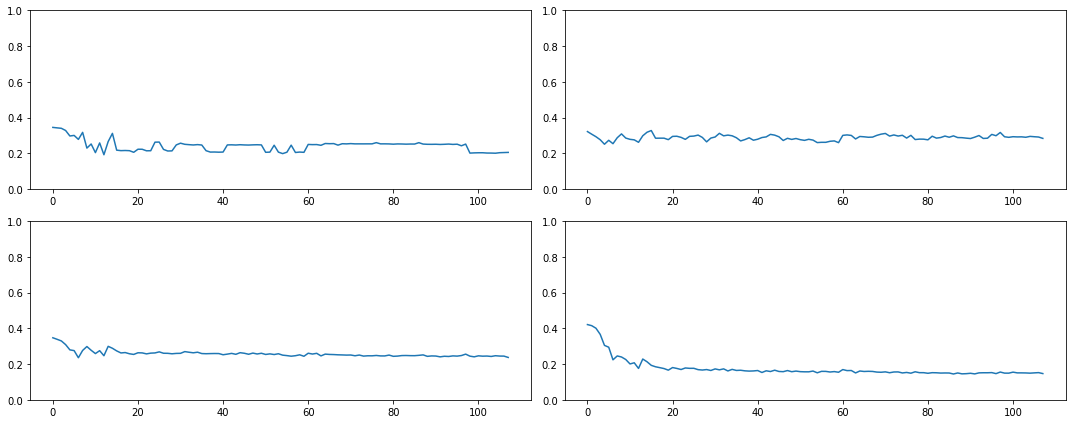

<IPython.core.display.Javascript object>

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h, (19, 22)))
    ax.set_ylim(0, 1)
plt.tight_layout()

In [84]:
#export
def get_learn_run(nfs,
                  data,
                  lr,
                  layer,
                  cbs=None,
                  opt_func=None,
                  uniform=False,
                  **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

<IPython.core.display.Javascript object>

In [85]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

<IPython.core.display.Javascript object>

In [86]:
learn, run = get_learn_run(nfs,
                           data,
                           1.,
                           conv_layer,
                           cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

<IPython.core.display.Javascript object>

In [87]:
run.fit(8, learn)

/Users/imad/Documents/courses/fastai-courses/dl2/notebooks/exp/nb_05.py:81: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


train: [0.90313421875, tensor(0.7217)]
valid: [0.31957158203125, tensor(0.9033)]
train: [0.4285191015625, tensor(0.8726)]
valid: [0.268347900390625, tensor(0.9228)]
train: [0.22835201171875, tensor(0.9305)]
valid: [0.1210226318359375, tensor(0.9647)]
train: [0.2021801953125, tensor(0.9398)]
valid: [0.10974852294921875, tensor(0.9690)]
train: [0.08877041015625, tensor(0.9723)]
valid: [0.09725418701171876, tensor(0.9731)]
train: [0.0612192333984375, tensor(0.9804)]
valid: [0.07212850952148438, tensor(0.9786)]
train: [0.04611478515625, tensor(0.9852)]
valid: [0.06451901245117188, tensor(0.9818)]
train: [0.037999384765625, tensor(0.9883)]
valid: [0.06382180786132813, tensor(0.9818)]


<IPython.core.display.Javascript object>

Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [88]:
learn, run = get_learn_run(nfs,
                           data,
                           1.,
                           conv_layer,
                           uniform=True,
                           cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

<IPython.core.display.Javascript object>

In [89]:
run.fit(8, learn)

train: [1.008134375, tensor(0.6830)]
valid: [0.2874323486328125, tensor(0.9208)]
train: [0.3834827734375, tensor(0.8844)]
valid: [0.222142529296875, tensor(0.9316)]
train: [0.1913426953125, tensor(0.9421)]
valid: [0.2109849853515625, tensor(0.9313)]
train: [0.12417845703125, tensor(0.9609)]
valid: [0.09965156860351562, tensor(0.9712)]
train: [0.08821607421875, tensor(0.9723)]
valid: [0.08993819580078125, tensor(0.9747)]
train: [0.059223115234375, tensor(0.9815)]
valid: [0.07526221923828125, tensor(0.9777)]
train: [0.0431268994140625, tensor(0.9866)]
valid: [0.06899884643554688, tensor(0.9800)]
train: [0.0349894091796875, tensor(0.9895)]
valid: [0.0689950439453125, tensor(0.9799)]


<IPython.core.display.Javascript object>

## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [90]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python ../src/notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

<IPython.core.display.Javascript object>

In [91]:
nb_auto_export()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>